## Medical

In [1]:
from math import *
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
import cv2
import keras
from keras.models import Sequential, model_from_yaml, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Convolution2D, Flatten, \
    MaxPooling2D,Input, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.python.ops import array_ops
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.applications.densenet import DenseNet169
from keras_applications.resnext import ResNeXt50
import albumentations
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

print(device_lib.list_local_devices())
config = tf.ConfigProto(device_count={"CPU": 1, "GPU" : 1})
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15206175070276794567
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6712789416347097058
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
train_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([albumentations.CLAHE(clip_limit=2), 
                         albumentations.IAASharpen(), 
                         albumentations.IAAEmboss(), 
        albumentations.RandomBrightness(), 
                         albumentations.RandomContrast(),
        albumentations.Blur(), 
                          albumentations.GaussNoise(),
                          albumentations.ElasticTransform(),
                         ], p=0.25), 
        albumentations.HueSaturationValue(p=0.25), 
        albumentations.ShiftScaleRotate(shift_limit=0.10, scale_limit=0.10, rotate_limit=0, p=0.5),
        albumentations.Normalize(p=1)
    
    ])

val_transform = albumentations.Compose([
    albumentations.Normalize(p=1)
    ])

test_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.Normalize(p=1)
    ])

def preprocess_train(image):
    return (train_transform(image = image.astype(np.uint8))['image'])

def preprocess_val(image):
    return (val_transform(image = image.astype(np.uint8))['image'])
    
def preprocess_test(image):
    return (test_transform(image = image.astype(np.uint8))['image'])

def preprocess_np(image):
    return (image.astype(np.uint8))


In [3]:
class NPGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=32, indep=np.empty([0,96,96,3]), dep = np.empty([0]), transform = preprocess_train):
        'Initialization'
        self.batch_size = batch_size
        self.indep = indep
        self.dep = dep
        self.index = 0
        self.transform = transform
        self.tr = (lambda x: transform(image=x))
        
    def __len__(self):
        l = int(np.floor(len(self.indep) / self.batch_size))
        if ((len(self.indep) % self.batch_size) >0):
            l+=1
        return l

    def __getitem__(self, index):
        X, y = self.indep[self.index * self.batch_size:(self.index + 1) * self.batch_size], \
               self.dep[self.index * self.batch_size:(self.index + 1) * self.batch_size]
            
        X = np.array([self.tr(img.astype(np.uint8)).reshape(96,96,3) for img in X])   
        
        self.index +=1
        if (self.index>=self.indep.shape[0]/self.batch_size):
            self.index=0    
        return X, y

    def reset(self):
        self.index=0
    

In [4]:
from keras.callbacks import *

class CyclicLR(Callback):
 
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        


In [5]:
def KerasFocalLoss(target, input):
    
    gamma = 2.
    input = tf.cast(input, tf.float32)
    
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

In [6]:
def getfold(n):
    val_folds = [(a + n) % 20 for a in range(0,2)]
    train_folds = [(a + n + 2) % 20 for a in range(0,6)]
    random.shuffle(train_folds)
    
    indep = np.empty([0,96,96,3])
    dep = np.empty([0])
    indep_val = np.empty([0,96,96,3])
    dep_val = np.empty([0])
    
    for i in val_folds:
        indep_val = np.append(indep_val, np.load("indep_{0}.npy".format(i)), axis=0)
        dep_val = np.append(dep_val, np.load("dep_{0}.npy".format(i)), axis=0)
        
    for i in train_folds:
        indep = np.append(indep, np.load("indep_{0}.npy".format(i)), axis=0)
        dep = np.append(dep, np.load("dep_{0}.npy".format(i)), axis=0)
    
    return indep, dep, indep_val, dep_val

In [ ]:
with tf.device('/device:GPU:0'):
    for i in range (0, 20):
        K.clear_session()
        indep, dep, indep_val, dep_val, res = None, None, None, None, None
        indep, dep, indep_val, dep_val = getfold(i)
        inputs = Input((96, 96, 3))
        base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
        x = base_model(inputs)
        x.Trainable=False
        out = Flatten()(x)
        out = Dense(256, activation='relu')(out)
        out = Dropout(0.5)(out)
        out = BatchNormalization()(out)
        out = Dense(64, activation='relu')(out)
        out = Dropout(0.5)(out)
        out = BatchNormalization()(out)
        out = Dense(1, activation='sigmoid')(out)
        
        gs1 = Model(inputs, out)
        gs1.compile(Adam(lr=0.001), loss="binary_crossentropy", metrics=['accuracy']) 

        with open(r"med_dn169_{0}.yaml".format(i), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())
        with open(r"med_dn169_{0}.yaml".format(i+20), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())
        with open(r"med_dn169_{0}.yaml".format(i+40), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())
        clr_triangular = CyclicLR(base_lr=5e-6, max_lr=0.005, mode="triangular2", step_size=1000)
        gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                          validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                          steps_per_epoch=indep.shape[0]/2/64,
                          validation_steps=indep_val.shape[0]/64,
                          epochs=100, verbose=1, callbacks = 
                          [
                          ModelCheckpoint("med_dn169_{0}.h5".format(i), monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
                          ModelCheckpoint("med_dn169_{0}.h5".format(i+40), monitor='acc', verbose=1, save_best_only=True, mode='max'),
                          ])
        gs1.save_weights("med_dn169_{0}.h5".format(i+20))
        

In [23]:
res = np.load("res.npy")
data = pd.DataFrame()
model =[]
for i in range(40, 60):
    with open(r"med_dn169_{0}.yaml".format(i), "r") as yaml_file:
        K.clear_session()
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"med_dn169_{0}.h5".format(i))
        for j in range(0,16):
            print (i, j)
            tg = NPGenerator(indep=res, batch_size=640, transform=preprocess_test)
            a = m.predict_generator(tg ,verbose=1, steps=len(tg))
            data["model_{0}".format(i * 16 + j)] = pd.Series(a.reshape(len(a)))

40 0
90/90 [==============================] - 81s 905ms/step
40 1
90/90 [==============================] - 80s 892ms/step
40 2
90/90 [==============================] - 80s 893ms/step
40 3
90/90 [==============================] - 80s 892ms/step
40 4
90/90 [==============================] - 81s 895ms/step
40 5
90/90 [==============================] - 80s 889ms/step
40 6
90/90 [==============================] - 80s 892ms/step
40 7
90/90 [==============================] - 80s 888ms/step
40 8
90/90 [==============================] - 79s 882ms/step
40 9
90/90 [==============================] - 79s 876ms/step
40 10
90/90 [==============================] - 79s 874ms/step
40 11
90/90 [==============================] - 80s 889ms/step
40 12
90/90 [==============================] - 80s 892ms/step
40 13
90/90 [==============================] - 80s 889ms/step
40 14
90/90 [==============================] - 80s 885ms/step
40 15
90/90 [==============================] - 80s 886ms/step
41 0
90/90 [======

90/90 [==============================] - 80s 892ms/step
56 12
90/90 [==============================] - 80s 885ms/step
56 13
90/90 [==============================] - 81s 896ms/step
56 14
90/90 [==============================] - 80s 887ms/step
56 15
90/90 [==============================] - 80s 894ms/step
57 0
90/90 [==============================] - 87s 964ms/step
57 1
90/90 [==============================] - 82s 916ms/step
57 2
90/90 [==============================] - 83s 920ms/step
57 3
90/90 [==============================] - 83s 926ms/step
57 4
90/90 [==============================] - 83s 918ms/step
57 5
90/90 [==============================] - 83s 919ms/step
57 6
90/90 [==============================] - 82s 910ms/step
57 7
90/90 [==============================] - 83s 921ms/step
57 8
90/90 [==============================] - 83s 917ms/step
57 9
90/90 [==============================] - 83s 924ms/step
57 10
90/90 [==============================] - 83s 921ms/step
57 11
90/90 [===========

In [35]:
with tf.device('/device:GPU:0'):
    for i in range (40, 60):
        with open(r"med_dn169_{0}.yaml".format(i), "r") as yaml_file:
            K.clear_session()
            indep, dep, indep_val, dep_val, res = None, None, None, None, None
            indep, dep, indep_val, dep_val = getfold(i)
            gs1 = model_from_yaml(yaml_file.read())
            gs1.load_weights("med_dn169_{0}.h5".format(i))
            rn = gs1.layers[1]
            
#            rn.Trainable = False
#            set_trainable = False
#            for layer in rn.layers:
#                if layer.name == 'res5a_branch2a':
#                    set_trainable = True
#                if set_trainable:
#                    layer.trainable = True
#                else:
#                    layer.trainable = False
            rn.Trainable = True
            for layer in rn.layers:
                layer.trainable = True


            gs1.compile(RMSprop(lr=0.00001), loss="binary_crossentropy", metrics=['accuracy'])
            clr_triangular = CyclicLR(base_lr=1e-6, max_lr=0.00001, mode="triangular2", step_size=1000)
        
            with open(r"med_dn169_5_l{0}.yaml".format(i-40), "w") as yaml_file:
                yaml_file.write(gs1.to_yaml())
            gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                          validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                          steps_per_epoch=indep.shape[0]/2/64,
                          validation_steps=indep_val.shape[0]/64,
                          epochs=10, verbose=1, callbacks = 
                          [
                              ModelCheckpoint("med_dn169_l{0}.h5".format(i-40), monitor='acc', verbose=1, save_best_only=True, mode='max'),
                              clr_triangular
                          ])
            

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
395/394 [==============================] - 214s 542ms/step - loss: 0.2317 - acc: 0.9233 - val_loss: 0.5901 - val_acc: 0.8181

Epoch 00001: acc improved from -inf to 0.92330, saving model to med_dn169_l0.h5
Epoch 2/10
395/394 [==============================] - 179s 453ms/step - loss: 0.0850 - acc: 0.9709 - val_loss: 0.5362 - val_acc: 0.8233

Epoch 00002: acc improved from 0.92330 to 0.97087, saving model to med_dn169_l0.h5
Epoch 3/10
395/394 [==============================] - 177s 447ms/step - loss: 0.1846 - acc: 0.9354 - val_loss: 0.5785 - val_acc: 0.8201

Epoch 00003: acc did not improve from 0.97087
Epoch 4/10
395/394 [==============================] - 180s 455ms/step - loss: 0.0749 - acc: 0.9750 - val_loss: 0.5003 - val_acc: 0.8286

Epoch 00004: acc improved from 0.97087 to 0.97502, saving model to med_dn169_l0.h5
Epoch 5/10
395/394 [==============================] - 174s 439ms/step - loss: 0.1548 - acc: 0.9447 - val_loss: 0

Epoch 10/10
421/420 [==============================] - 198s 470ms/step - loss: 0.1557 - acc: 0.9449 - val_loss: 0.4795 - val_acc: 0.8546

Epoch 00010: acc did not improve from 0.94886
Epoch 1/10
441/440 [==============================] - 234s 531ms/step - loss: 0.2191 - acc: 0.9211 - val_loss: 0.3189 - val_acc: 0.8760

Epoch 00001: acc improved from -inf to 0.92110, saving model to med_dn169_l4.h5
Epoch 2/10
441/440 [==============================] - 207s 469ms/step - loss: 0.1883 - acc: 0.9316 - val_loss: 0.3685 - val_acc: 0.8632

Epoch 00002: acc improved from 0.92110 to 0.93170, saving model to med_dn169_l4.h5
Epoch 3/10
441/440 [==============================] - 206s 468ms/step - loss: 0.1825 - acc: 0.9391 - val_loss: 0.3487 - val_acc: 0.8751

Epoch 00003: acc improved from 0.93170 to 0.93906, saving model to med_dn169_l4.h5
Epoch 4/10
441/440 [==============================] - 208s 472ms/step - loss: 0.1623 - acc: 0.9433 - val_loss: 0.3840 - val_acc: 0.8628

Epoch 00004: acc impro

449/448 [==============================] - 192s 429ms/step - loss: 0.1616 - acc: 0.9455 - val_loss: 0.2029 - val_acc: 0.9400

Epoch 00010: acc did not improve from 0.95584
Epoch 1/10
443/442 [==============================] - 211s 477ms/step - loss: 0.2225 - acc: 0.9185 - val_loss: 0.3420 - val_acc: 0.9055

Epoch 00001: acc improved from -inf to 0.91849, saving model to med_dn169_l8.h5
Epoch 2/10
443/442 [==============================] - 188s 424ms/step - loss: 0.1021 - acc: 0.9631 - val_loss: 0.3008 - val_acc: 0.8639

Epoch 00002: acc improved from 0.91849 to 0.96305, saving model to med_dn169_l8.h5
Epoch 3/10
443/442 [==============================] - 187s 421ms/step - loss: 0.1913 - acc: 0.9286 - val_loss: 0.3219 - val_acc: 0.9136

Epoch 00003: acc did not improve from 0.96305
Epoch 4/10
443/442 [==============================] - 186s 420ms/step - loss: 0.0960 - acc: 0.9652 - val_loss: 0.2988 - val_acc: 0.8657

Epoch 00004: acc improved from 0.96305 to 0.96513, saving model to med_

Epoch 1/10
445/444 [==============================] - 218s 489ms/step - loss: 0.3977 - acc: 0.8340 - val_loss: 0.2548 - val_acc: 0.9094

Epoch 00001: acc improved from -inf to 0.83402, saving model to med_dn169_l12.h5
Epoch 2/10
445/444 [==============================] - 193s 435ms/step - loss: 0.3318 - acc: 0.8685 - val_loss: 0.2453 - val_acc: 0.9210

Epoch 00002: acc improved from 0.83402 to 0.86856, saving model to med_dn169_l12.h5
Epoch 3/10
445/444 [==============================] - 199s 447ms/step - loss: 0.2644 - acc: 0.8989 - val_loss: 0.1920 - val_acc: 0.9450

Epoch 00003: acc improved from 0.86856 to 0.89891, saving model to med_dn169_l12.h5
Epoch 4/10
445/444 [==============================] - 206s 463ms/step - loss: 0.2702 - acc: 0.8956 - val_loss: 0.2020 - val_acc: 0.9403

Epoch 00004: acc did not improve from 0.89891
Epoch 5/10
445/444 [==============================] - 197s 444ms/step - loss: 0.2192 - acc: 0.9221 - val_loss: 0.1876 - val_acc: 0.9471

Epoch 00005: acc imp

410/409 [==============================] - 223s 543ms/step - loss: 0.3286 - acc: 0.9010 - val_loss: 0.8757 - val_acc: 0.7716

Epoch 00001: acc improved from -inf to 0.90095, saving model to med_dn169_l16.h5
Epoch 2/10
410/409 [==============================] - 195s 477ms/step - loss: 0.1479 - acc: 0.9468 - val_loss: 1.3105 - val_acc: 0.7204

Epoch 00002: acc improved from 0.90095 to 0.94676, saving model to med_dn169_l16.h5
Epoch 3/10
410/409 [==============================] - 210s 512ms/step - loss: 0.2666 - acc: 0.9147 - val_loss: 0.9230 - val_acc: 0.7627

Epoch 00003: acc did not improve from 0.94676
Epoch 4/10
410/409 [==============================] - 208s 508ms/step - loss: 0.1320 - acc: 0.9542 - val_loss: 1.3198 - val_acc: 0.7142

Epoch 00004: acc improved from 0.94676 to 0.95419, saving model to med_dn169_l16.h5
Epoch 5/10
410/409 [==============================] - 208s 506ms/step - loss: 0.2377 - acc: 0.9204 - val_loss: 0.9326 - val_acc: 0.7535

Epoch 00005: acc did not improv

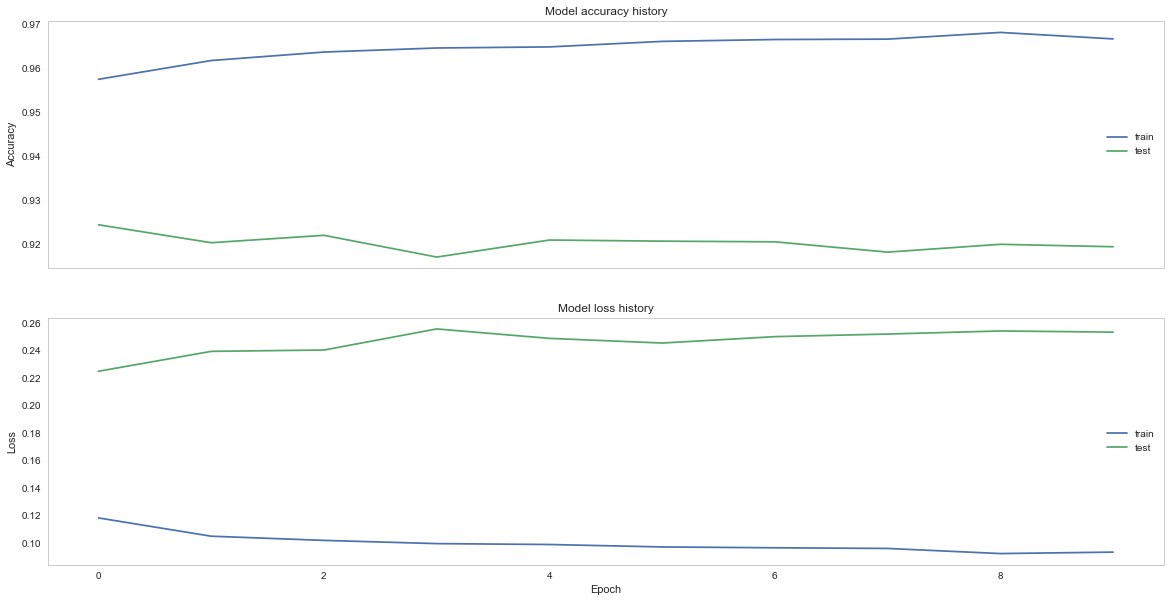

In [27]:
fig, ax = plt.subplots(2, 1, sharex='col', figsize=(20, 10))
ax[0].set_title('Model accuracy history')
ax[0].plot(gs1.history.history['acc'])
ax[0].plot(gs1.history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc='right')
ax[0].grid()

ax[1].set_title('Model loss history')
ax[1].plot(gs1.history.history['loss'])
ax[1].plot(gs1.history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc='right')
ax[1].grid()
plt.xlabel('Epoch')
plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
    for i in range (0, 9):
        with open(r"med_dn169_lll{0}.yaml".format(i), "r") as yaml_file:
            K.clear_session()
            indep, dep, indep_val, dep_val, res = None, None, None, None, None
            indep, dep, indep_val, dep_val = getfold(i+10)
            gs1 = model_from_yaml(yaml_file.read())
            gs1.load_weights("med_dn169_lll{0}.h5".format(i))
            rn = gs1.layers[1]
            rn.Trainable = True
            for layer in rn.layers:
                layer.trainable = True


            gs1.compile(RMSprop(lr=0.001), loss="binary_crossentropy", metrics=['accuracy'])
            clr_triangular = CyclicLR(base_lr=1e-5, max_lr=0.0001, mode="triangular2", step_size=2000)
        
            with open(r"med_dn169_llll{0}.yaml".format(i), "w") as yaml_file:
                yaml_file.write(gs1.to_yaml())
            gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                          validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                          steps_per_epoch=indep.shape[0]/64,
                          validation_steps=indep_val.shape[0]/64,
                          epochs=5, verbose=1, callbacks = 
                          [
                              ModelCheckpoint("med_dn169_llll{0}.h5".format(i), monitor='acc', verbose=1, save_best_only=True, mode='max'),
                          ])


In [ ]:
res = np.load("res.npy")
data = pd.DataFrame()
model =[]
for i in range(0, 9):
    with open(r"med_dn169_lll{0}.yaml".format(i), "r") as yaml_file:
        K.clear_session()
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"med_dn169_lll{0}.h5".format(i))
        for j in range(0,4):
            print (i, j)
            tg = NPGenerator(indep=res, batch_size=640, transform=preprocess_test)
            a = m.predict_generator(tg ,verbose=1, steps=len(tg))
            data["model_{0}".format(i * 10 + j)] = pd.Series(a.reshape(len(a)))

0 0
90/90 [==============================] - 90s 995ms/step
0 1
90/90 [==============================] - 85s 947ms/step
0 2
90/90 [==============================] - 85s 941ms/step
0 3
90/90 [==============================] - 87s 967ms/step
1 0
90/90 [==============================] - 85s 939ms/step
1 1
90/90 [==============================] - 80s 891ms/step
1 2
90/90 [==============================] - 80s 894ms/step
1 3
90/90 [==============================] - 82s 913ms/step
2 0
90/90 [==============================] - 82s 911ms/step
2 1
90/90 [==============================] - 83s 920ms/step
2 2
90/90 [==============================] - 81s 901ms/step
2 3
90/90 [==============================] - 81s 900ms/step
3 0
90/90 [==============================] - 82s 911ms/step
3 1
69/90 [======================>.......] - ETA: 19s

In [ ]:
test_generator = ImageDataGenerator().flow_from_directory(directory=r"c:/users/ajaln/test/",
                                                    target_size=(96, 96),
                                                    color_mode="rgb", batch_size=1000,
                                                    class_mode="binary", shuffle=False)
result = pd.DataFrame()
result["id"] = test_generator.filenames
result["id"] = result["id"].str[5:45]
result["label"] = data.iloc[:,:].mean(axis=1)
result.head()
samples = pd.read_csv(r"c:/users/ajaln/sample_submission.csv", usecols=["id"])
samples = pd.merge(samples, result, on="id", how="inner")
samples.head()
samples.to_csv(r"c:/work/dataset/medical/medical_dn169_tl.csv", index=False)

In [ ]:
data.to_csv(r"c:/work/dataset/medical/medical_dn169_data.csv", index=False)

In [17]:
a2 = pd.read_csv(r"C:/Work/dataset/medical/medical_dn169_tl.csv")
a = pd.read_csv(r"C:/Work/dataset/medical/kl2.csv")

a["label"] = (a2["label"]*0.5+a["label"]*0.5)
a.loc[:, ["id", "label"]].to_csv(r"c:/work/dataset/medical/last.csv", index=False)

In [20]:
list = [y+x*4 for x in [2,5,6,7,12,13,14,15] for y in [0,1,2,3]]
list

[8,
 9,
 10,
 11,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]